In [77]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import eetools, saveModule
from osgeo import gdal

In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

In [3]:
coordenadas = "-48.53801472648439,-22.503806214013736,-48.270222978437516,-22.7281869567509"
x1, y1, x2, y2 = coordenadas.split(",")

datas = "2020-01-01,2020-12-31"
inicio, fim = datas.split(",")
escala = 30
dummy_value = 99999

geom = ee.Geometry.Polygon([[[float(x1),float(y2)],
                             [float(x2),float(y2)],
                             [float(x2),float(y1)],
                             [float(x1),float(y1)],
                             [float(x1),float(y2)]]])

latitude_central = (float(x1)+float(x2))/2
longitude_central = (float(y1)+float(y2))/2

In [4]:
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
    .filterBounds(geom)\
    .filterDate(inicio,fim)

In [5]:
sentinel1

In [6]:
v_emit = sentinel1.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
                  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
                  .filter(ee.Filter.eq('instrumentMode', 'IW'))

In [7]:
v_emit_asc = v_emit.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
v_emit_desc = v_emit.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

In [8]:
v_emit_desc

In [9]:
my_map = geemap.Map(center=(longitude_central, latitude_central), zoom=11)
my_map.addLayer(geom)

rgb = ee.Image.rgb(
    v_emit_desc.mean().select('VV'),
    v_emit_desc.mean().select('VH'),
    v_emit_desc.mean().select('VV').divide(v_emit_desc.mean().select('VH'))
).clip(geom)

my_map.addLayer(rgb, {'min': [-25,-25,0], 'max': [0,0,2]})

my_map

Map(center=[-22.61599658538232, -48.404118852460954], controls=(WidgetControl(options=['position', 'transparen…

In [24]:
def add_amplitude(image, VV = "VV", VH = "VH"):
    amplitude = image\
        .expression('(VV ** 2 + VH ** 2) ** (1 / 2)', {'VV':image.select(VV), 'VH':image.select(VH)})\
        .rename('amplitude')
    return image.addBands(amplitude)

In [25]:
image = v_emit_desc.median()

image_amp = add_amplitude(image)
image_amp

In [26]:
my_map2 = geemap.Map(center=(longitude_central, latitude_central), zoom=11)
my_map2.addLayer(geom)

rgb = ee.Image.rgb(
    image_amp.select('VV'),
    image_amp.select('VH'),
    image_amp.select('amplitude')
).clip(geom)

my_map2.addLayer(rgb, {'min': [-30,-30,0], 'max': [1,1,2]})

my_map2

Map(center=[-22.61599658538232, -48.404118852460954], controls=(WidgetControl(options=['position', 'transparen…

In [27]:
def extrair_lonlat(imagem, geometria, bandas, scale=30):
    imagem = imagem.addBands(ee.Image.pixelLonLat())
    
    coordenadas = imagem.select(["longitude","latitude"] + bandas)\
        .reduceRegion(reducer=ee.Reducer.toList(),
                     geometry=geometria,
                     scale=scale,
                     bestEffort=True)
    
    coordenadas = coordenadas.getInfo()
    
    return pd.DataFrame.from_dict(coordenadas)

In [28]:
image = ee.Image(dummy_value).blend(v_emit_desc.map(add_amplitude).select('amplitude').toBands())
image_names = image.bandNames().getInfo()

df = extrair_lonlat(image, geom, image_names, scale=10)
df

,S1A_IW_GRDH_1SDV_20200104T083855_20200104T083920_030648_03832D_B27B_amplitude,S1A_IW_GRDH_1SDV_20200116T083854_20200116T083919_030823_03894C_C5F9_amplitude,S1A_IW_GRDH_1SDV_20200128T083854_20200128T083919_030998_038F78_F944_amplitude,S1A_IW_GRDH_1SDV_20200209T083854_20200209T083919_031173_03958F_9F83_amplitude,S1A_IW_GRDH_1SDV_20200221T083853_20200221T083918_031348_039B92_202E_amplitude,S1A_IW_GRDH_1SDV_20200304T083853_20200304T083918_031523_03A1A2_1555_amplitude,S1A_IW_GRDH_1SDV_20200316T083854_20200316T083919_031698_03A7B1_4449_amplitude,S1A_IW_GRDH_1SDV_20200328T083854_20200328T083919_031873_03ADDA_F477_amplitude,S1A_IW_GRDH_1SDV_20200409T083854_20200409T083919_032048_03B40A_F2B5_amplitude,S1A_IW_GRDH_1SDV_20200421T083855_20200421T083920_032223_03BA2D_B3D6_amplitude,...,S1A_IW_GRDH_1SDV_20201006T083903_20201006T083928_034673_0409E6_53DC_amplitude,S1A_IW_GRDH_1SDV_20201018T083903_20201018T083928_034848_04100A_74ED_amplitude,S1A_IW_GRDH_1SDV_20201030T083903_20201030T083928_035023_0415F4_73C5_amplitude,S1A_IW_GRDH_1SDV_20201111T083903_20201111T083928_035198_041C17_DD4C_amplitude,S1A_IW_GRDH_1SDV_20201123T083903_20201123T083928_035373_042222_26AF_amplitude,S1A_IW_GRDH_1SDV_20201205T083902_20201205T083927_035548_042828_DC7D_amplitude,S1A_IW_GRDH_1SDV_20201217T083902_20201217T083927_035723_042E31_4146_amplitude,S1A_IW_GRDH_1SDV_20201229T083901_20201229T083926_035898_043452_2EF1_amplitude,latitude,longitude
0,20.716899,20.341120,22.451369,20.125621,22.192122,20.203974,19.356166,22.090348,22.759075,22.956831,...,26.911320,27.203558,22.534765,23.874732,18.702302,20.510357,19.160141,18.494387,-22.728118,-48.537906
1,17.694414,17.669109,20.035479,19.080890,19.392424,21.617007,17.728264,16.188380,16.311598,15.271240,...,18.567384,14.285951,18.710707,16.081257,16.385917,16.867936,15.478335,20.750575,-22.728118,-48.537461
2,16.131689,17.903040,16.490825,14.340238,17.315019,16.366185,15.205005,13.381444,15.944717,17.096541,...,14.892600,17.511547,17.137704,18.151758,15.751512,13.467632,15.235117,13.068701,-22.728118,-48.537016
3,18.224191,16.481674,17.167379,17.574950,15.313163,15.982812,15.785406,16.163242,18.392932,16.991408,...,17.149274,17.194140,15.841260,17.354306,19.122995,16.517664,17.168179,15.123768,-22.728118,-48.536570
4,16.114590,15.305584,18.093339,15.302582,17.670867,17.392273,16.526430,17.759688,15.582288,15.461505,...,16.729699,15.652866,15.425011,15.056599,17.120426,14.170507,14.113654,14.888036,-22.728118,-48.536125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303403,21.085924,21.824920,19.983590,19.464874,17.628312,22.733920,22.822535,21.806923,18.491133,19.833738,...,26.945802,24.837585,18.104238,22.695096,23.581710,21.202182,19.191509,18.139297,-22.504135,-48.272065
303404,20.384310,20.458257,19.798715,18.385947,19.485537,19.924180,20.411393,19.734124,19.423192,21.411383,...,29.173209,25.253744,19.501830,23.619651,22.985671,19.689458,19.117080,18.578074,-22.504135,-48.271619
303405,21.240245,21.986217,19.035188,18.855435,18.636603,20.949149,19.390030,19.845263,21.573947,21.362505,...,28.345055,25.234918,18.353593,21.850191,20.128960,20.719147,22.246140,19.335022,-22.504135,-48.271174
303406,21.024320,22.184688,22.127009,20.512548,18.994243,19.282620,20.249328,20.906195,21.060660,18.852837,...,26.070704,23.101061,17.428776,22.754252,20.182718,22.348412,20.393644,19.783075,-22.504135,-48.270729


## Exportando

In [29]:
from src import saveModule

In [42]:
export = df.iloc[:,[0,1,2,31,32]]
export_columns = list(export.drop(['latitude','longitude'], axis = 1).columns)
export_columns

['S1A_IW_GRDH_1SDV_20200104T083855_20200104T083920_030648_03832D_B27B_amplitude',
 'S1A_IW_GRDH_1SDV_20200116T083854_20200116T083919_030823_03894C_C5F9_amplitude',
 'S1A_IW_GRDH_1SDV_20200128T083854_20200128T083919_030998_038F78_F944_amplitude']

In [45]:
saveModule.save_tiff_from_df(
    export,
    export_columns,
    99999,
    "assets/amplitude.tif",
    "EPSG:4326"   
)

True

In [46]:
from osgeo import gdal
filepath = r"assets/amplitude.tif"
raster = gdal.Open(filepath)
type(raster)

osgeo.gdal.Dataset

In [47]:
raster.RasterCount

3

In [48]:
array = raster.GetRasterBand(3).ReadAsArray()
array.shape

(504, 602)

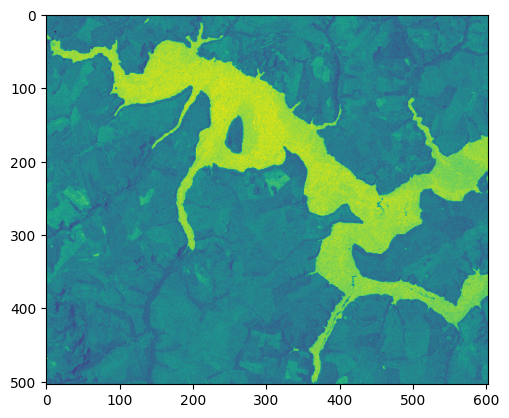

In [49]:
plt.imshow(array)

## Análise de Série Temporal

In [55]:
y = df.drop(['latitude','longitude'], axis=1).iloc[0,:]

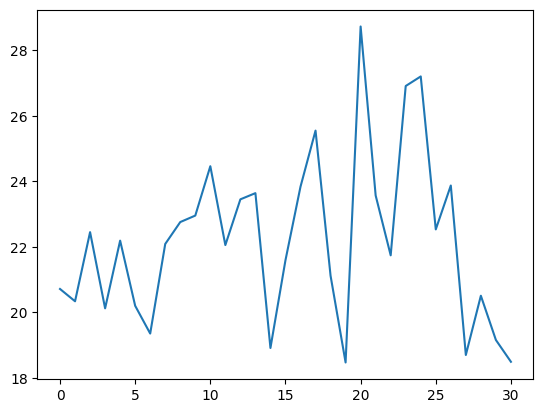

In [61]:
plt.plot(pd.Series(range(0, len(y))), y)

In [62]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.robjects as robjects

rpy2.robjects.numpy2ri.activate()
pandas2ri.activate()

astsa = importr('astsa')
base = importr('base')
stats = importr('stats')

In [64]:
r_time_series = stats.ts(robjects.FloatVector(y))
r_ts_scaled = base.scale(r_time_series)
specenv_res = astsa.specenv(base.cbind(r_ts_scaled, abs(r_ts_scaled), r_ts_scaled**2), real=True, plot=False)
specenv_res

array([[ 0.03125   ,  0.25624267, -0.32622771, -0.925448  ,  0.19266935],
       [ 0.0625    ,  0.12567812,  0.16389175, -0.88308189,  0.43966563],
       [ 0.09375   ,  0.10847242,  0.49179015, -0.844879  ,  0.21052772],
       [ 0.125     ,  0.15130068,  0.50580393,  0.65881253, -0.55689176],
       [ 0.15625   ,  0.05984894, -0.23276418, -0.8597255 ,  0.45463491],
       [ 0.1875    ,  0.11378045, -0.15353936, -0.85143417,  0.50148333],
       [ 0.21875   ,  0.18175021,  0.47001128, -0.86322598, -0.18420181],
       [ 0.25      ,  0.15689778, -0.08116569, -0.88459372,  0.45924511],
       [ 0.28125   ,  0.27129032, -0.2067467 , -0.94450444,  0.25527861],
       [ 0.3125    ,  0.19808672, -0.18229594, -0.98039894,  0.07474024],
       [ 0.34375   ,  0.10727791, -0.07178899, -0.94814122,  0.30963619],
       [ 0.375     ,  0.27265171,  0.39924195, -0.89430152,  0.20206597],
       [ 0.40625   ,  0.02979871, -0.30874689, -0.57349322,  0.75880227],
       [ 0.4375    ,  0.3189586 , -0.0

In [75]:
def get_specenv(x, *args): 
    scaled_time_series  = base.scale(stats.ts(robjects.FloatVector(list(x))))

    return args



(1, 2, 3)

In [97]:
[i(np.array(y)) for i in (np.abs, lambda j: j ** 2)]

[array([20.71689926, 20.3411201 , 22.45136874, 20.12562131, 22.19212243,
        20.20397406, 19.35616594, 22.09034769, 22.75907462, 22.95683107,
        24.46339456, 22.0568201 , 23.45248905, 23.64179012, 18.9156147 ,
        21.59508288, 23.83904751, 25.55055806, 21.12086775, 18.47342725,
        28.72818639, 23.57032871, 21.74401504, 26.91132046, 27.20355821,
        22.53476526, 23.87473198, 18.70230174, 20.51035686, 19.1601408 ,
        18.49438723]),
 array([429.18991489, 413.7611669 , 504.06395835, 405.04063301,
        492.49029791, 408.20056782, 374.66115973, 487.98346103,
        517.97547743, 527.01609265, 598.45767318, 486.50331296,
        550.01924259, 558.93424031, 357.8004795 , 466.34760444,
        568.30018622, 652.83101711, 446.09105448, 341.26751426,
        825.30869338, 555.56039566, 472.80219004, 724.21916874,
        740.0335791 , 507.81564545, 570.00282715, 349.77609053,
        420.67473853, 367.1109956 , 342.04235918])]